In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb


import os
import warnings

from pathlib import Path

#Configurations
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Directories and Filenames
Contains paths and filenames to access test and training data.

In [7]:
ROOT_DIR = Path.cwd().parent
SRC_DIR = os.path.join(ROOT_DIR, 'src')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

processed_training_data_path = os.path.join(DATA_DIR, 'train_processed.csv')
processed_test_data_path = os.path.join(DATA_DIR, 'test_processed.csv')

In [8]:
df_train = pd.read_csv(processed_training_data_path)
df_unseen_test = pd.read_csv(processed_test_data_path)

In [9]:
# x7_cols = [col for col in df_train.columns if col.startswith('x7_')]

# df_train_polka = df_train[df_train['x7_Polka'] == 1]
# df_train_polka = df_train_polka.drop(x7_cols, axis=1)

# df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
# df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

# df_train_schottis = df_train[df_train['x7_Schottis'] == 1]
# df_train_schottis = df_train_schottis.drop(x7_cols, axis=1)

# df_train_polskor = df_train[(df_train['x7_Polskor'] == 1) | (df_train['x7_Slängpolskor'] == 1)]
# df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)

# df_train_hambo = df_train[df_train['x7_Hambo'] == 1]
# df_train_hambo = df_train_hambo.drop(x7_cols, axis=1)

# df_train_x12_1 = df_train[df_train['x12_True'] == 1]
# df_train_x12_1 = df_train_x12_1.drop('x12_True', axis=1)

# df_train_x12_0 = df_train[df_train['x12_True'] == 0]
# df_train_x12_0 = df_train_x12_0.drop('x12_True', axis=1)

## Train, Validation and Test Splits & Modeling

In [10]:
df_test = df_train.sample(frac=0.2, random_state=42)
df_train = df_train.drop(df_test.index)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Unseen test shape: {df_unseen_test.shape}")

df_train.head()

Train shape: (790, 7)
Test shape: (197, 7)
Unseen test shape: (10000, 6)


,x4,x5,x8,x9,x10,x11,y
0,0.041297,0.168716,1.243974,0.323734,-0.275316,-0.462594,2
1,0.505788,-0.394709,-0.343594,-0.401810,-0.042394,0.763768,0
2,0.476071,-0.055452,0.888450,0.078986,-1.363136,-0.845952,1
3,0.279145,-0.166733,-0.935800,-0.617531,0.041439,-0.285398,2
4,0.952232,-1.010925,-1.471067,1.137805,0.408868,-0.852787,1


In [11]:
from catboost import CatBoostClassifier

def train_different_models(x_train, y_train):
    
    from sklearn.model_selection import GridSearchCV

    xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)

    xgb_parameters = {
        'n_estimators': [30, 50, 70, 100, 200, 300],
        'max_depth': [3, 5, 7, 8, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    }

    cb_model = CatBoostClassifier(random_state=42, verbose=False)

    # cb_parameters = {
    #     'iterations': [ 50, 100, 300],
    #     'depth': [5, 10, 15],
    #     'learning_rate': [0.01, 0.1, 0.2],
    # }


    #Define custom scoring function according to weighted f1 score for each class
    from sklearn.metrics import f1_score, make_scorer

    def weighted_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    scoring = make_scorer(weighted_f1_score, greater_is_better=True)

    xgb_cv = GridSearchCV(xgb_model, xgb_parameters, cv=10, n_jobs=-1, scoring=scoring)
    xgb_cv.fit(x_train, y_train)

    #cb_cv = GridSearchCV(cb_model, cb_parameters, cv=5, n_jobs=-1, scoring=scoring, verbose=1)
    # cb_cv.fit(x_train, y_train)
    cb_model.fit(x_train, y_train)

    return xgb_cv, cb_model

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score

def evaluate_model(model_predictions, model_labels, model):
    fig, ax = plt.subplots(figsize=(12, 8))
    cm = confusion_matrix(model_labels, model_predictions)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.show()

    #print(classification_report(model_labels, model_predictions))
    #print(f"Weighted F1 Score across all classes: {f1_score(model_labels, model_predictions, average='weighted')}")
    return f1_score(model_labels, model_predictions, average='weighted')

def train_and_evaluate_different_models_for_splits(dataframes, labels, upsample = False):
    xgb_models = {}
    cb_models = {}
    f1_scores_xgb = {}
    f1_scores_cb = {}
    sample_sizes = []

    for name, df in zip(labels, dataframes):
        x_train, x_val, y_train, y_val = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=0.2, random_state=42, stratify=df['y'])

        if upsample:
            x_train, y_train = upsample_training_data_with_SMOTE(x_train, y_train)

        sample_sizes.append(x_train.shape[0])

        xgb_model, cb_model = train_different_models(x_train, y_train)
        xgb_models[f"{name}_xgb"] = xgb_model
        cb_models[f"{name}_cb"] = cb_model

        xgb_predictions = xgb_model.predict(x_val)
        cb_predictions = cb_model.predict(x_val)

        f1_scores_xgb[f"{name}_xgb"] = evaluate_model(xgb_predictions, y_val, xgb_model)
        f1_scores_cb[f"{name}_cb"] = evaluate_model(cb_predictions, y_val, cb_model)
    
    
    weights = sample_sizes / np.sum(sample_sizes)
    print(f" Weighted overall f1_scores_xgb: {weights.dot(list(f1_scores_xgb.values())).mean()}")
    print(f" Weighted overall f1_scores_cb: {weights.dot(list(f1_scores_cb.values())).mean()}")

    return xgb_models, f1_scores_xgb, cb_models, f1_scores_cb

def upsample_training_data_with_SMOTE(x_train, y_train):
    from imblearn.over_sampling import SMOTE

    #print class distribution before SMOTE
    # print("Before SMOTE: ", y_train.value_counts())

    sm = SMOTE(random_state=42, n_jobs=-1)
    x_train, y_train = sm.fit_resample(x_train, y_train)

    #print class distribution after SMOTE
    # print("After SMOTE: ", y_train.value_counts())

    return x_train, y_train

In [13]:
#Train and evaluate separate models
# data_by_x5 = [df_train_polka, df_train_schottis, df_train_polskor, df_train_hambo]

# labels = ['Polka', 'Schottis', 'Polskor', 'Hambo']

# xgb_models, f1_xgb = train_and_evaluate_different_models_for_splits(data_by_x5, labels, upsample=True)
# f1_xgb

In [14]:
# df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
# df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

# df_train_polskor = df_train[(df_train['x7_Polskor'] == 1) | (df_train['x7_Slängpolskor'] == 1)]
# df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)


# data_by_x5 = [df_train_polka, df_train_schottis, df_train_slängpolskor, df_train_polskor, df_train_hambo]

# labels = ['Polka', 'Schottis', 'Slängpolskor', 'Polskor', 'Hambo']

# xgb_models, f1_xgb = train_and_evaluate_different_models_for_splits(data_by_x5, labels, upsample=True)

In [15]:
# x12_dfs = [df_train_x12_1, df_train_x12_0]
# x12_labels = ['x12_True', 'x12_False']

# xgb_models_x12 = train_and_evaluate_different_models_for_splits(x12_dfs, x12_labels)

[12:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


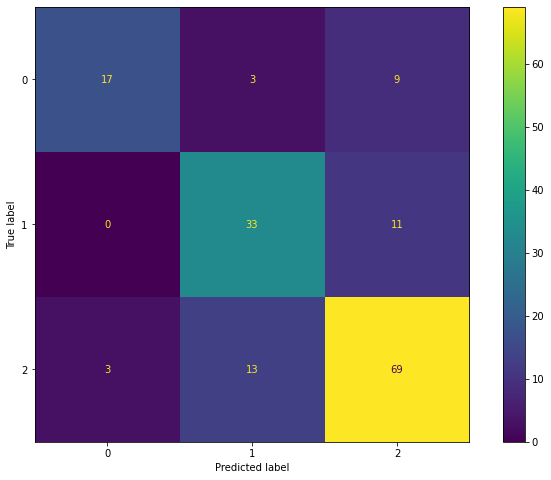

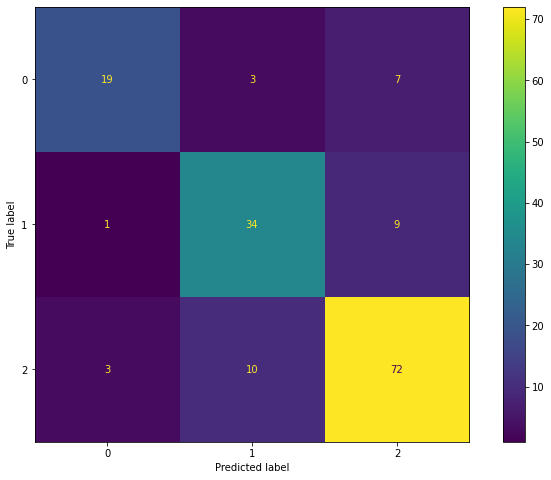

 Weighted overall f1_scores_xgb: 0.7516585350294493
 Weighted overall f1_scores_cb: 0.7900181877097074


In [16]:
xgb_model_all, f1_xgb_all, cb_model_all, f1_cb_all = train_and_evaluate_different_models_for_splits([df_train], ['All'])

In [76]:
xgb_model_all_us, f1_xgb_all_us, cb_model_all_us, f1_cb_all_us = train_and_evaluate_different_models_for_splits([df_train], ['All'], upsample=True)

Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


KeyboardInterrupt: 

In [62]:
def evaluate_performance_on_test_set(model, df_test):
    x_test = df_test.drop(['y'], axis=1)
    y_test = df_test['y']

    predictions = model.predict(x_test)

    f1_score = evaluate_model(predictions, y_test, model)

    return f1_score

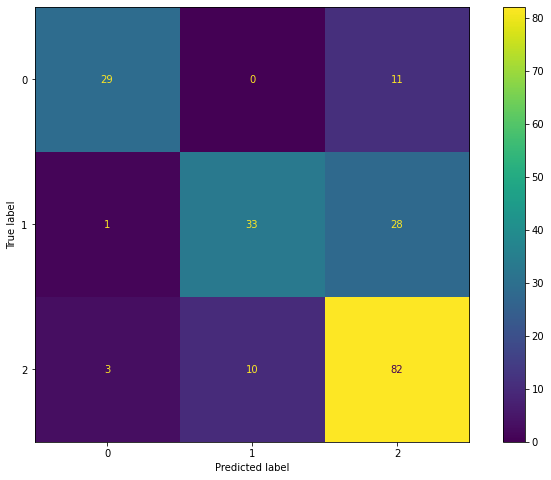

0.7252887315678498

In [77]:
evaluate_performance_on_test_set(xgb_model_all['All_xgb'], df_test)

In [119]:
# evaluate_performance_on_test_set(cb_model_all_us['All_cb'], df_test)

## CatBoost Parameter Tuning



In [124]:
from sklearn.metrics import f1_score
import optuna

In [125]:
def objective(trial,data=df_train.drop(['y'], axis=1), target= df_train['y']):

    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss","MultiClassOneVsAll", "MultiClass"]),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)



        
    # Set up a kfold test
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    f1_scores = []
    for train_index, test_index in kf.split(train_x):
        x_train, x_val = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

        # Upsample training data
        x_train, y_train = upsample_training_data_with_SMOTE(x_train, y_train)
        
        model = CatBoostClassifier(**param)  
        model.fit(x_train,y_train,eval_set=[(x_val, y_val)], verbose=0, early_stopping_rounds=100)
        preds = model.predict(x_val)

        f1_scores.append(f1_score(y_val, preds, average='weighted'))

    ## Full model
    # Split and upsample
    # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)
    # train_x, train_y = upsample_training_data_with_SMOTE(train_x, train_y)
    # model = CatBoostClassifier(**param)  
    # model.fit(train_x,train_y,eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)
    # preds = model.predict(test_x)

    f1_wei = np.mean(f1_scores)

    return f1_wei

In [126]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-06-13 15:09:36,605] A new study created in memory with name: no-name-7d5fc502-41cd-4fbb-9ed5-4d4acf55d70b


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:38,814] Trial 0 finished with value: 0.798139921901617 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.28782045718673}. Best is trial 0 with value: 0.798139921901617.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:39,860] Trial 1 finished with value: 0.7921751126450159 and parameters: {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.766453786472213}. Best is trial 0 with value: 0.798139921901617.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:41,145] Trial 2 finished with value: 0.7426027651726242 and parameters: {'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.25926135969106}. Best is trial 0 with value: 0.798139921901617.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:41,930] Trial 3 finished with value: 0.7675515220146484 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.73134363496198}. Best is trial 0 with value: 0.798139921901617.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:43,270] Trial 4 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.7983821655268674.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:45,104] Trial 5 finished with value: 0.7796242297858501 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.7983821655268674.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:48,521] Trial 6 finished with value: 0.810613420296312 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.821067151758501}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:49,116] Trial 7 finished with value: 0.7929451135012219 and parameters: {'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21438480716627428}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:50,399] Trial 8 finished with value: 0.7864234144202645 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:51,504] Trial 9 finished with value: 0.7733441036741437 and parameters: {'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.293488874698232}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:52,746] Trial 10 finished with value: 0.7425134396604415 and parameters: {'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9793043449470504}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:54,587] Trial 11 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:55,789] Trial 12 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:56,811] Trial 13 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:09:59,002] Trial 14 finished with value: 0.7859541740105751 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11244228989739291}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:00,491] Trial 15 finished with value: 0.7670887165954348 and parameters: {'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7781069090286072}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:02,895] Trial 16 finished with value: 0.7796242297858501 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:04,586] Trial 17 finished with value: 0.7862037109174607 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.0690941318497496}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:06,090] Trial 18 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:07,612] Trial 19 finished with value: 0.7923098036683027 and parameters: {'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6345645385081262}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:09,051] Trial 20 finished with value: 0.7864234144202645 and parameters: {'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:11,244] Trial 21 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:14,130] Trial 22 finished with value: 0.7796242297858501 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:15,601] Trial 23 finished with value: 0.7983821655268674 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:17,460] Trial 24 finished with value: 0.7796242297858501 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:19,156] Trial 25 finished with value: 0.7857045429816932 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.287275051014599}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:19,672] Trial 26 finished with value: 0.7990930940554398 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:21,690] Trial 27 finished with value: 0.7990930940554398 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:22,320] Trial 28 finished with value: 0.7988943584935145 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.511941870663442}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:24,881] Trial 29 finished with value: 0.7752553852986898 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.311679325062886}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:26,063] Trial 30 finished with value: 0.7356933440975267 and parameters: {'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.524543373921947}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:27,162] Trial 31 finished with value: 0.7732313329120427 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5440421591154421}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:27,831] Trial 32 finished with value: 0.7927623500194124 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4331918586033916}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:28,690] Trial 33 finished with value: 0.7925762871247716 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7061291570246562}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:29,452] Trial 34 finished with value: 0.7858955313730867 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3640060768589717}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:31,366] Trial 35 finished with value: 0.8042721518987342 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.969912692550696}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:32,628] Trial 36 finished with value: 0.8042721518987342 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.908869941064679}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:34,504] Trial 37 finished with value: 0.781006997540315 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.938371027760683}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:35,805] Trial 38 finished with value: 0.8042721518987342 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.07231528313775}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:36,916] Trial 39 finished with value: 0.7684926935087846 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.88099221799665}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:37,588] Trial 40 finished with value: 0.8041074468872603 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.788197634685481}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:38,225] Trial 41 finished with value: 0.8042721518987342 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.821185813666519}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:39,582] Trial 42 finished with value: 0.7906610725543032 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.273613395982346}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:41,309] Trial 43 finished with value: 0.7923118759401488 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.015190000633801}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:43,288] Trial 44 finished with value: 0.7906610725543032 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.201564725429409}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:44,072] Trial 45 finished with value: 0.7980907626229544 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.090307091533997}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:45,576] Trial 46 finished with value: 0.7978814961933134 and parameters: {'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.8283014558355815}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:46,188] Trial 47 finished with value: 0.7618748228606557 and parameters: {'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.455333235827497}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:46,802] Trial 48 finished with value: 0.7868028033764927 and parameters: {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.363827840477986}. Best is trial 6 with value: 0.810613420296312.


Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


[I 2023-06-13 15:10:48,937] Trial 49 finished with value: 0.7867422556869843 and parameters: {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.651690387057831}. Best is trial 6 with value: 0.810613420296312.


Number of finished trials: 50
Best trial: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.821067151758501}


In [127]:
optuna.visualization.plot_param_importances(study)

Before SMOTE:  2    426
1    219
0    145
Name: y, dtype: int64
After SMOTE:  2    426
0    426
1    426
Name: y, dtype: int64


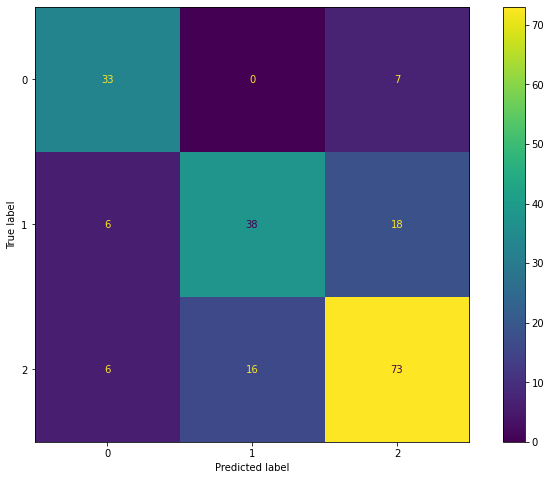

0.728653797759784

In [128]:
model = CatBoostClassifier(verbose=0)
x_train, y_train = upsample_training_data_with_SMOTE(df_train.drop(['y'], axis=1), df_train['y'])
# x_train,y_train = df_train.drop(['y'], axis=1), df_train['y']
model.fit(x_train, y_train)
evaluate_performance_on_test_set(model, df_test)

Before SMOTE:  2    426
1    219
0    145
Name: y, dtype: int64
After SMOTE:  2    426
0    426
1    426
Name: y, dtype: int64
Learning rate set to 0.080123
0:	learn: 1.0541462	total: 6.77ms	remaining: 6.77s
1:	learn: 1.0101004	total: 12.8ms	remaining: 6.4s
2:	learn: 0.9760872	total: 19.3ms	remaining: 6.41s
3:	learn: 0.9429870	total: 25.6ms	remaining: 6.37s
4:	learn: 0.9130624	total: 31.2ms	remaining: 6.22s
5:	learn: 0.8876983	total: 37.1ms	remaining: 6.15s
6:	learn: 0.8702097	total: 42.9ms	remaining: 6.09s
7:	learn: 0.8554156	total: 49.4ms	remaining: 6.13s
8:	learn: 0.8394507	total: 55.6ms	remaining: 6.12s
9:	learn: 0.8150689	total: 61.2ms	remaining: 6.06s
10:	learn: 0.8000196	total: 67.5ms	remaining: 6.07s
11:	learn: 0.7860943	total: 73.9ms	remaining: 6.08s
12:	learn: 0.7681370	total: 80.3ms	remaining: 6.1s
13:	learn: 0.7551495	total: 86.4ms	remaining: 6.08s
14:	learn: 0.7452769	total: 92.5ms	remaining: 6.07s
15:	learn: 0.7397811	total: 99.6ms	remaining: 6.12s
16:	learn: 0.7295105	to

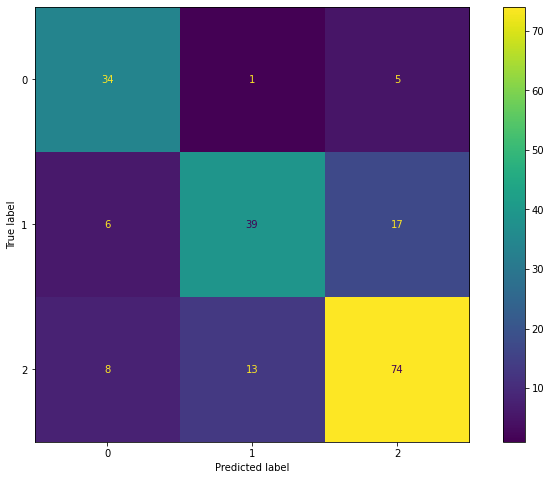

0.7440295952647744

In [134]:
model = CatBoostClassifier(**study.best_trial.params)
# model = CatBoostClassifier(verbose=0, boosting_type= 'Plain', bootstrap_type= 'MVS')
x_train, y_train = upsample_training_data_with_SMOTE(df_train.drop(['y'], axis=1), df_train['y'])
# x_train,y_train = df_train.drop(['y'], axis=1), df_train['y']
model.fit(x_train, y_train)
evaluate_performance_on_test_set(model, df_test)